In [0]:
#FashionMNIST CNN

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
from sklearn.metrics import confusion_matrix

In [0]:
batch_size = 100

#Importing Fashion MNIST dataset

#Transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

#Training set
train_set = torchvision.datasets.FashionMNIST(root='./data/FashionMNIST', train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

#Test set
test_set = torchvision.datasets.FashionMNIST(root='./data/FashionMNIST', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [0]:
#Neural network

class NnFashionClassifier(nn.Module):
  def __init__(self):
    super().__init__()

    #Layers
    #Conv 1
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
    self.conv1_b = nn.BatchNorm2d(16)

    #Conv 2
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.conv2_b = nn.BatchNorm2d(32)

    #Conv 3
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.conv3_b = nn.BatchNorm2d(64)


    self.d1 = nn.Linear(in_features=3*3*64, out_features=120)
    self.d2 = nn.Linear(in_features=120, out_features=60)
    self.out = nn.Linear(in_features=60, out_features=10)


  def forward(self, x):
    #conv1
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv1_b(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2)

    #conv2
    x = self.conv2(x)
    x = F.relu(x)
    x = self.conv2_b(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2)

    #conv3
    x = self.conv3(x)
    x = F.relu(x)
    x = self.conv3_b(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2)

    #d1
    x = x.reshape(-1, 3*3*64)
    x = self.d1(x)
    x = F.relu(x)

    #d2
    x = self.d2(x)
    x = F.relu(x)

    #Logits
    logits = self.out(x)
    out = F.softmax(logits, dim=1)
    
    return out

In [4]:
#Test model
model = NnFashionClassifier()
for images, labels in train_loader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break
print(model)

batch size: torch.Size([100, 1, 28, 28])
torch.Size([100, 10])
NnFashionClassifier(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_b): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_b): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (d1): Linear(in_features=576, out_features=120, bias=True)
  (d2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)


In [0]:
learning_rate = 0.0002
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = NnFashionClassifier()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Compute accuracy
def get_accuracy(logit, target, batch_size):
    #Obtain accuracy for training round
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [6]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    #Training step
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)

        #Forward, backprop, loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        #Update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, batch_size)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))

Epoch: 0 | Loss: 1.7088 | Train Accuracy: 79.01
Epoch: 1 | Loss: 1.6243 | Train Accuracy: 84.43
Epoch: 2 | Loss: 1.6135 | Train Accuracy: 85.36
Epoch: 3 | Loss: 1.5985 | Train Accuracy: 86.90
Epoch: 4 | Loss: 1.5623 | Train Accuracy: 90.48


In [7]:
test_acc = 0.0

#For confusion matrix
list_predictions = []
list_labels = []

#Get test accuracy
for i, (images, labels) in enumerate(test_loader, 0):
    images = images.to(device)
    labels = labels.to(device)

    list_labels.append(labels)

    outputs = model(images)
    predictions = torch.max(outputs, 1)[1].to(device)
    list_predictions.append(predictions)

    test_acc += get_accuracy(outputs, labels, batch_size)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 90.14


 Confusion matrix:
 [[837   0   8  25   2   1 121   0   6   0]
 [  0 972   2  17   4   0   4   0   1   0]
 [ 16   1 787  11  75   0 109   0   1   0]
 [  8   5   7 913  27   1  39   0   0   0]
 [  1   0  26  35 816   1 119   0   2   0]
 [  0   0   0   1   0 979   0  17   0   3]
 [115   3  34  29  77   0 735   0   7   0]
 [  0   0   0   0   0  19   0 965   0  16]
 [  3   1   0   4   3   3   8   3 975   0]
 [  0   0   0   0   0   8   1  45   1 945]]


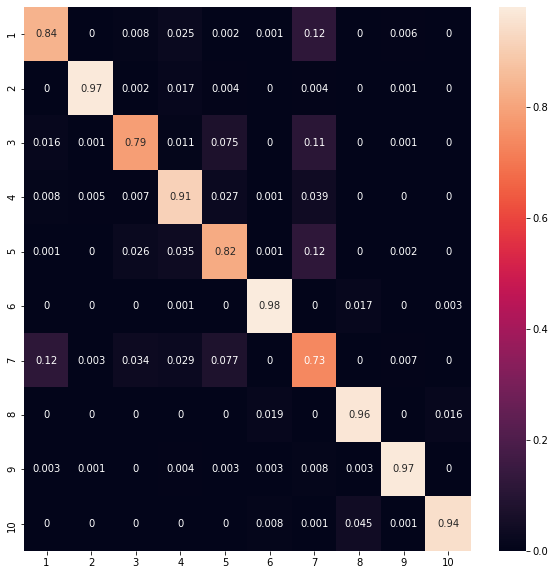

In [8]:
from itertools import chain
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

#Make arrays for predictions and labels
predictions_l = [list_predictions[i].tolist() for i in range(len(list_predictions))]
labels_l = [list_labels[i].tolist() for i in range(len(list_labels))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

#Confusion matrix (Not normalized)
array = confusion_matrix(labels_l, predictions_l)
print(" Confusion matrix:\n", array)

#Normalize and plot confusion matrix
array = array.astype('float') / array.sum(axis=1)[:, np.newaxis]
c_matrix = pd.DataFrame(array, index = [i for i in range(1, 11)],\
                        columns = [i for i in range(1, 11)])
plt.figure(figsize=(10, 10))
sn.heatmap(c_matrix, annot=True)
plt.show()
